# PD Notebook


## Attributes of Peridynamic Material Points:

|Variable Name|Description|Symbol|
|:------------|:-----------|:-----|
|coord|Components of position in x and y|$x$|
|volume|Cubic Volume of PD point|$V$|
|disp|Components of displacement in x and y|$u$|
|SED|Strain Energy Density of PD point|$W$|
|Dilatation|Dilatation of PD Point|$\theta$|
|pforce|Summation of PD forces due to interactions|$$\sum_{j=1}^{N}(t_{ij})-t_{ji})V_j$$|
|bforce|Body force over PD point|$b$|
|vel|Components of velocity at nth iteration  in x and y|$\dot{u}^{n}$|
|velhalf|Components of velocity at (n+1/2)th iteration  in x and y|$\dot{u}^{n+1/2}$|
|massvec|Diagonal Components of Fictitious Mass Matrix|$\lambda_{ii}$|
|S,D|Surface Correction Terms of SED and Dilatationfor their corresponding Loading Conditions|$D_i, S_i$|
|old|Stored components of previous iterations|$()^{n-1}$

![title](fig1.jpg)

In [1]:
def get_neighbors(df,current_id,horizon):
    distance=((df.coordx-df.loc[current_id].coordx)**2+(df.coordy-df.loc[current_id].coordy)**2)**0.5
    neighbor_ids = distance[distance<=horizon].index
    neighbor_ids=neighbor_ids.drop(current_id)
    idist = ((df.loc[neighbor_ids].coordx-df.loc[current_id].coordx)**2+(df.loc[neighbor_ids].coordy-df.loc[current_id].coordy)**2)**0.5
    idist.name = 'idist'
    return neighbor_ids,idist

In [2]:
def compute_nlength(df,current_id,neighbor_ids):
    nlength = (((df.loc[current_id].coordx + df.loc[current_id].dispx)-(df.loc[neighbor_ids].coordx + df.loc[neighbor_ids].dispx))**2+((df.loc[current_id].coordy + df.loc[current_id].dispy)-(df.loc[neighbor_ids].coordy + df.loc[neighbor_ids].dispy))**2)
    nlength.name = 'nlength'
    return nlength

![title](fig2.jpg)

In [3]:
def compute_stretch(nlength,idist):
    stretch = nlength/idist
    stretch.name = 'stretch'
    return stretch

![title](fig3.png)

![title](fig4.png)

In [4]:
def compute_fac_volume_cor(idist,horizon,delta):
    r = delta/2
    fac_volume_corr=pandas.Series(index=idist.index,dtype='float32')
    fac_volume_corr[idist[idist<=horizon-r].index]=1.
    fac_volume_corr[idist[idist>horizon-r][idist[idist>horizon-r]<=horizon+r].index]=(horizon+r)-idist.loc[idist[idist>horizon-r][idist[idist>horizon-r]<=horizon+r].index]/2/r
    fac_volume_corr[idist[idist>horizon+r].index]=0.
    fac_volume_corr.name = 'fac_volume_corr'
    return fac_volume_corr

![title](fig5.png)

In [5]:
def compute_Lambda(df,current_id,neighbor_ids,idist,nlength):
    ykx=(df.loc[current_id].dispx+df.loc[current_id].coordx)
    yky=(df.loc[current_id].dispy+df.loc[current_id].coordy)
    yjx=(df.loc[neighbor_ids].dispx+df.loc[neighbor_ids].coordx)
    yjy=(df.loc[neighbor_ids].dispy+df.loc[neighbor_ids].coordy)
    xkx=(df.loc[current_id].coordx)
    xky=(df.loc[current_id].coordy)
    xjx=(df.loc[neighbor_ids].coordx)
    xjy=(df.loc[neighbor_ids].coordy)
    Lambda=((yjx-ykx)*(xjx-xkx)+(yjy-yky)*(xjy-xky))/idist/nlength
    Lambda.name = 'Lambda'
    return Lambda

![title](fig6.png)

![title](fig7.png)

In [6]:
def compute_Dilatation(df,current_id,neighbor_ids,stretch,fac_volume_corr,Lambda,horizon,d):
    Dilatation = horizon*d*Lambda*stretch*df.loc[neighbor_ids].volume * fac_volume_corr
    Dilatation.name = 'Dilatation'
    return Dilatation

![title](fig8.png)

In [7]:
def compute_SED(df,current_id,neighbor_ids,nlength,idist,fac_volume_corr,horizon,b,Dilatation,a):
    SED = horizon*b*((nlength-idist))**2 /idist * df.loc[neighbor_ids].volume*fac_volume_corr
    SED.name = 'SED'
    return SED

In [8]:
def construct_dfn(idist,nlength,stretch,fac_volume_corr,Lambda,Dilatation,SED):
    dfn = pandas.DataFrame()
    dfn[idist.name]=idist
    dfn[nlength.name]=nlength
    dfn[fac_volume_corr.name]=fac_volume_corr
    dfn[Lambda.name]=Lambda
    dfn[Dilatation.name]=Dilatation
    dfn[SED.name]=SED
    return dfn

![title](fig9.png)

In [9]:
def set_surface_correction_factors(df,current_id,condition,disp_grad,SED):
    if condition=='uniaxial stretch x':
        df.loc[current_id].D1 = disp_grad / df.loc[current_id].Dilatation
        df.loc[current_id].Dilatation = df.loc[current_id].Dilatation *df.loc[current_id].D1 
    elif condition=='uniaxial stretch y':
        df.loc[current_id].D2 = disp_grad / df.loc[current_id].Dilatation
        df.loc[current_id].Dilatation = df.loc[current_id].Dilatation *df.loc[current_id].D2 
    elif condition=='simple shear in x-y':
        df.loc[current_id].S1 = 0.5*disp_grad**2*mu / SED.sum()
        df.loc[current_id].S2 = 0.5*disp_grad**2*mu / SED.sum()
        df.loc[current_id].SED = SED.sum()*df.loc[current_id].S1

In [10]:
def preprocess(df,condition_list,disp_grad):
    for condition in condition_list:
        set_loading_condition(condition,df,disp_grad)
        for current_id in df.index:
            neighbor_ids,idist=get_neighbors(df,current_id,horizon)
            nlength=compute_nlength(df,current_id,neighbor_ids)
            stretch=compute_stretch(nlength,idist)
            fac_volume_corr=compute_fac_volume_cor(idist,horizon,delta)
            Lambda=compute_Lambda(df,current_id,neighbor_ids,idist,nlength)
            Dilatation=compute_Dilatation(df,current_id,neighbor_ids,stretch,fac_volume_corr,Lambda,horizon,d)
            df.loc[current_id].Dilatation= Dilatation.sum()
            SED=compute_SED(df,current_id,neighbor_ids,nlength,idist,fac_volume_corr,horizon,b,Dilatation,a)
            df.loc[current_id].SED = a*Dilatation.sum()**2 + SED.sum()
            dfn=construct_dfn(idist,nlength,stretch,fac_volume_corr,Lambda,Dilatation,SED)
            set_surface_correction_factors(df,current_id,condition,disp_grad,SED)

In [11]:
def surface_correction_vector(df,current_id,neighbor_ids,idist):
    gdx=(df.loc[current_id].D1 + df.loc[neighbor_ids].D1)*0.5
    gdy=(df.loc[current_id].D2 + df.loc[neighbor_ids].D2)*0.5
    gbx=(df.loc[current_id].S1 + df.loc[neighbor_ids].S1)*0.5
    gby=gbx
    nx=(df.loc[neighbor_ids].coordx-df.loc[current_id].coordx)/idist
    ny=(df.loc[neighbor_ids].coordy-df.loc[current_id].coordy)/idist
    Gd=((nx/gdx)**2+(ny/gdy)**2)**-0.5
    Gb=((nx/gbx)**2+(ny/gby)**2)**-0.5
    return Gd,Gd

In [12]:
def preprocess_with_SCF(df):
    for current_id in df.index:
        neighbor_ids,idist=get_neighbors(df,current_id,horizon)
        Gd, Gb =surface_correction_vector(df,current_id,neighbor_ids,idist)
        nlength=compute_nlength(df,current_id,neighbor_ids)
        stretch=compute_stretch(nlength,idist)
        fac_volume_corr=compute_fac_volume_cor(idist,horizon,delta)
        Lambda=compute_Lambda(df,current_id,neighbor_ids,idist,nlength)
        Dilatation=compute_Dilatation(df,current_id,neighbor_ids,stretch,fac_volume_corr,Lambda,horizon,d)
        Dilatation = Dilatation * Gd
        df.loc[current_id].Dilatation= Dilatation.sum()
        SED=compute_SED(df,current_id,neighbor_ids,nlength,idist,fac_volume_corr,horizon,b,Dilatation,a)
        SED = SED*Gb
        df.loc[current_id].SED = a*Dilatation.sum()**2 + SED.sum()
        dfn=construct_dfn(idist,nlength,stretch,fac_volume_corr,Lambda,Dilatation,SED)

In [13]:
def compute_PD_forces(df,current_id,neighbor_ids,idist,nlength,stretch,fac_volume_corr,Lambda):
    A = 2*horizon*(d*Lambda/idist*(a*df.loc[current_id].Dilatation)+b*(stretch))
    A.name = 'A'
    B = 2*horizon*(d*Lambda/idist*(a*df.loc[neighbor_ids].Dilatation)+b*(stretch))
    delyx =(df.loc[neighbor_ids].dispx +df.loc[neighbor_ids].coordx - (df.loc[current_id].dispx+df.loc[current_id].coordx))
    delyy = (df.loc[neighbor_ids].dispy +df.loc[neighbor_ids].coordy - (df.loc[current_id].dispy+df.loc[current_id].coordy))
    tkjx = 0.5 * A * delyx/nlength
    tkjy = 0.5 * A * delyy/nlength
    tjkx = -0.5 * B * delyx/nlength
    tjky = -0.5 * B * delyy/nlength
    pforcex = ((tkjx-tjkx)*fac_volume_corr*df.loc[neighbor_ids].volume).sum()
    pforcey = ((tkjy-tjky)*fac_volume_corr*df.loc[neighbor_ids].volume).sum()
    return pforcex, pforcey

In [14]:
def compute_stable_mass_vector(df,horizon,current_id,neighbor_ids,idist,fac_volume_corr,dt,a,safety_factor):
    Kijx = numpy.abs(df.loc[neighbor_ids].coordx-df.loc[current_id].coordx)/idist/idist * 4 * horizon * (0.5 * a * d**2 * horizon / idist * (df.loc[current_id].volume + df.loc[neighbor_ids].volume*fac_volume_corr)+((df.loc[current_id].bforcex)**2+(df.loc[current_id].bforcey)**2)**0.5)
    Kijy = numpy.abs(df.loc[neighbor_ids].coordy-df.loc[current_id].coordy)/idist/idist * 4 * horizon * (0.5 * a * d**2 * horizon / idist * (df.loc[current_id].volume + df.loc[neighbor_ids].volume*fac_volume_corr)+((df.loc[current_id].bforcex)**2+(df.loc[current_id].bforcey)**2)**0.5)
    massvecx = safety_factor*0.25*dt**2*Kijx.sum()
    massvecy = safety_factor*0.25*dt**2*Kijy.sum()
    return massvecx, massvecy

In [15]:
def compute_damping_coeff(df,dt):
    cn=0.
    cn_num=0.
    cn_denom=0.
    for current_id in df.index:
        if (df.loc[current_id].velhalfoldx!=0.):
            Kiix = -(df.loc[current_id].pforcex - df.loc[current_id].pforceoldx)/df.loc[current_id].massvecx/dt/df.loc[current_id].velhalfoldx
            cn_num=cn_num + df.loc[current_id].dispx*Kiix*df.loc[current_id].dispx
        if (df.loc[current_id].velhalfoldy!=0.):
            Kiiy = -(df.loc[current_id].pforcey - df.loc[current_id].pforceoldy)/df.loc[current_id].massvecy/dt/df.loc[current_id].velhalfoldy
            cn_num=cn_num + df.loc[current_id].dispy*Kiiy*df.loc[current_id].dispy
        cn_denom=cn_denom+df.loc[current_id].dispx**2
        cn_denom=cn_denom+df.loc[current_id].dispy**2
    if (cn_denom!=0.):
        if ((cn_num/cn_denom)>0.):
            cn = 2 * (cn_num/cn_denom)**0.5
        else:
            cn=0.
    else:
        cn=0.
    if (cn>2.):
        cn=1.9
    return cn

In [16]:
def apply_ADR(df,tt,dt,cn):
    for current_id in df.index:
        if(tt==1):
            df.loc[current_id].velhalfx = dt * (df.loc[current_id].pforcex+df.loc[current_id].bforcex)/df.loc[current_id].massvecx/2
            df.loc[current_id].velhalfy = dt * (df.loc[current_id].pforcey+df.loc[current_id].bforcey)/df.loc[current_id].massvecy/2
        else:
            df.loc[current_id].velhalfx = ((2.0 - cn * dt)*df.loc[current_id].velhalfoldx+2*dt*(df.loc[current_id].pforcex+df.loc[current_id].bforcex)/df.loc[current_id].massvecx)/(2+cn*dt)
            df.loc[current_id].velhalfy = ((2.0 - cn * dt)*df.loc[current_id].velhalfoldy+2*dt*(df.loc[current_id].pforcey+df.loc[current_id].bforcey)/df.loc[current_id].massvecy)/(2+cn*dt)
        df.loc[current_id].velx = (df.loc[current_id].velhalfoldx+df.loc[current_id].velhalfx)*0.5
        df.loc[current_id].vely = (df.loc[current_id].velhalfoldy+df.loc[current_id].velhalfy)*0.5
        df.loc[current_id].dispx=(df.loc[current_id].dispx+df.loc[current_id].velx*dt)
        df.loc[current_id].dispy=(df.loc[current_id].dispy+df.loc[current_id].vely*dt)
        df.loc[current_id].velhalfoldx = df.loc[current_id].velhalfx
        df.loc[current_id].velhalfoldy = df.loc[current_id].velhalfy
        df.loc[current_id].pforceoldx = df.loc[current_id].pforcex
        df.loc[current_id].pforceoldy = df.loc[current_id].pforcey

In [17]:
def iterate(df,ibcs,dt,max_iter,applied):
    set_loading_condition(ibcs,df,applied)
    for tt in range(1,max_iter+dt,dt):
        preprocess_with_SCF(df)
        print(tt)
        for current_id in df.index:
            neighbor_ids,idist=get_neighbors(df,current_id,horizon)
            nlength=compute_nlength(df,current_id,neighbor_ids)
            stretch=compute_stretch(nlength,idist)
            fac_volume_corr=compute_fac_volume_cor(idist,horizon,delta)
            Lambda=compute_Lambda(df,current_id,neighbor_ids,idist,nlength)
            pforcex, pforcey = compute_PD_forces(df,current_id,neighbor_ids,idist,nlength,stretch,fac_volume_corr,Lambda)
            df.loc[current_id].pforcex = pforcex
            df.loc[current_id].pforcey = pforcey
            massvecx, massvecy = compute_stable_mass_vector(df,horizon,current_id,neighbor_ids,idist,fac_volume_corr,dt,a,safety_factor=5)
            df.loc[current_id].massvecx = massvecx
            df.loc[current_id].massvecy = massvecy
        cn = compute_damping_coeff(df,dt)
        apply_ADR(df,tt,dt,cn)
        df.plot.scatter('coordx','dispx')

## Memory allocation with dummy values

In [18]:
import pandas, numpy, matplotlib
columns = ['coordx','coordy','volume','dispx','dispy','SED','Dilatation','D1','D2','S1','S2','pforcex','pforcey','bforcex','bforcey','massvecx','massvecy','pforceoldx','pforceoldy','velhalfoldx','velhalfoldy','velx','vely','velhalfx','velhalfy']
number_of_pd_points_per_edge = 30
#30x30 Collocation points with all attributes equal to -99999. with datatype float32
df = pandas.DataFrame(-99999*numpy.ones((number_of_pd_points_per_edge**2,len(columns)),dtype='float32'),columns=columns)


## Initializing Collocation Points with above Attributes

### Setting up a grid 30x30 with $\Delta = \Delta_{x} = \Delta_{y} = 1.$ and thickness = $10. \times \Delta$

In [19]:
current_id = 0
delta=1.
horizon = 3.015 * delta
dt = 1.
thickness = 10*delta
for i in range(0,number_of_pd_points_per_edge):
    for j in range(0,number_of_pd_points_per_edge):
        df.loc[current_id].coordx = i*delta
        df.loc[current_id].coordy = j*delta
        df.loc[current_id].volume = delta**2 * thickness
        current_id = current_id+1
df.plot.scatter('coordx','coordy')

### PD Material Properties for 2D Isotropic Structures

In [20]:
E = 200
nu = 1/3
kappa = E/3/(1-2*nu)
mu = E/2/(1+nu)
a = 0.5 * (kappa - 2*mu)
b = 6*mu/numpy.pi/thickness/horizon**4
d = 2 / numpy.pi/thickness/horizon**3

### Loading Conditions for Calculation of Surface Corrections and Testing the Model

In [21]:
def set_loading_condition(condition,df,applied):
    if condition == 'uniaxial stretch x':
        for id in df.index:
            df.loc[id].dispx = applied* df.loc[id].coordx
            df.loc[id].dispy = 0.
            df.loc[id].bforcex = 0.
            df.loc[id].bforcey = 0.   
            df.loc[id].velx = 0.
            df.loc[id].vely = 0.
            df.loc[id].velhalfx = 0.
            df.loc[id].velhalfy = 0.
            df.loc[id].velhalfoldx= 0.
            df.loc[id].velhalfoldy= 0.
    if condition == 'uniaxial stretch y':
        for id in df.index:
            df.loc[id].dispx = 0.
            df.loc[id].dispy = applied* df.loc[id].coordy
            df.loc[id].bforcex = 0.
            df.loc[id].bforcey = 0.   
            df.loc[id].velx = 0.
            df.loc[id].vely = 0.
            df.loc[id].velhalfx = 0.
            df.loc[id].velhalfy = 0.
            df.loc[id].velhalfoldx= 0.
            df.loc[id].velhalfoldy= 0.
    if condition == 'simple shear in x-y':
        for id in df.index:
            df.loc[id].dispx = 0.5*applied* df.loc[id].coordx
            df.loc[id].dispy = -0.5*applied* df.loc[id].coordy
            df.loc[id].bforcex = 0.
            df.loc[id].bforcey = 0.   
            df.loc[id].velx = 0.
            df.loc[id].vely = 0.
            df.loc[id].velhalfx = 0.
            df.loc[id].velhalfy = 0.
            df.loc[id].velhalfoldx= 0.
            df.loc[id].velhalfoldy= 0.
    if condition == 'uniaxial tensile loading':
        appres = applied
        left_bound=df[df.coordx==df.coordx.min()].index
        for id in left_bound:
            df.loc[id].bforcex = -1*appres/delta
            df.loc[id].bforcey = 0.
            df.loc[id].dispx = 0.
            df.loc[id].dispy = 0.
            df.loc[id].velx = 0.
            df.loc[id].vely = 0.
            df.loc[id].velhalfx = 0.
            df.loc[id].velhalfy = 0.
            df.loc[id].velhalfoldx= 0.
            df.loc[id].velhalfoldy= 0.
        right_bound=df[df.coordx==df.coordx.max()].index
        for id in right_bound:
            df.loc[id].bforcex = 1*appres/delta
            df.loc[id].bforcey = 0.
            df.loc[id].dispx = 0.
            df.loc[id].dispy = 0.
            df.loc[id].velx = 0.
            df.loc[id].vely = 0.
            df.loc[id].velhalfx = 0.
            df.loc[id].velhalfy = 0.
            df.loc[id].velhalfoldx= 0.
            df.loc[id].velhalfoldy= 0.
        for id in df.drop(index=left_bound).drop(index=right_bound).index:
            df.loc[id].bforcex = 0.
            df.loc[id].bforcey = 0.
            df.loc[id].dispx = 0.
            df.loc[id].dispy = 0.
            df.loc[id].velx = 0.
            df.loc[id].vely = 0.
            df.loc[id].velhalfx = 0.
            df.loc[id].velhalfy = 0.
            df.loc[id].velhalfoldx= 0.
            df.loc[id].velhalfoldy= 0.

In [22]:
condition_list = ['uniaxial stretch x','uniaxial stretch y','simple shear in x-y']
disp_grad=0.001
preprocess(df,condition_list,disp_grad)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


C:\Users\Aaron\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


22
23
24
25
26
27
28
29
30


KeyboardInterrupt: 

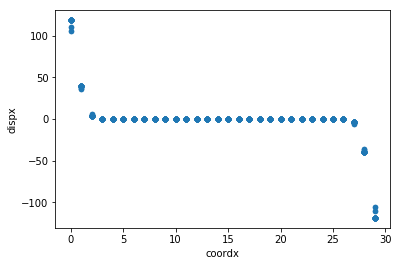

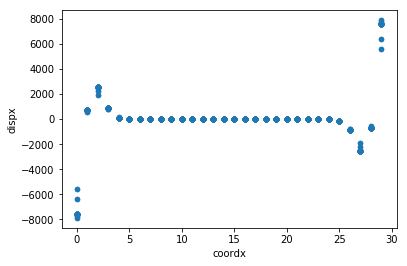

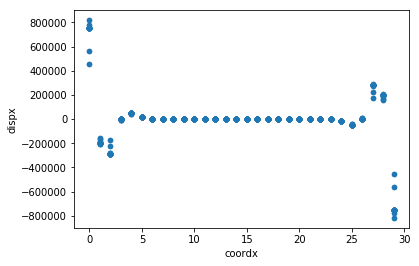

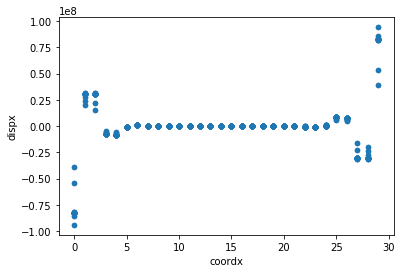

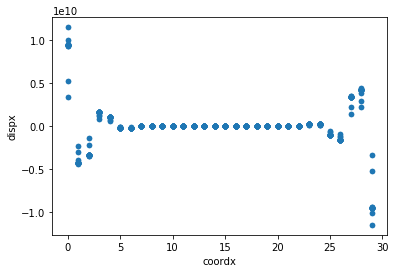

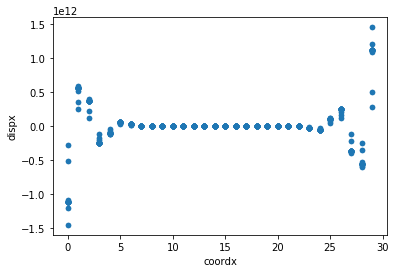

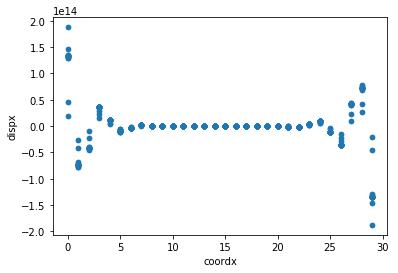

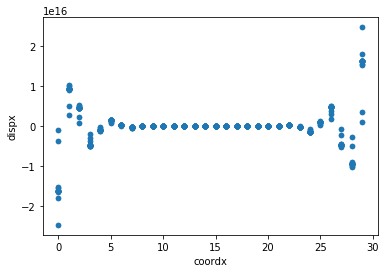

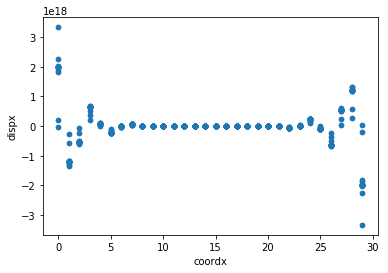

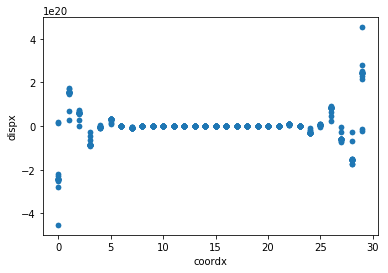

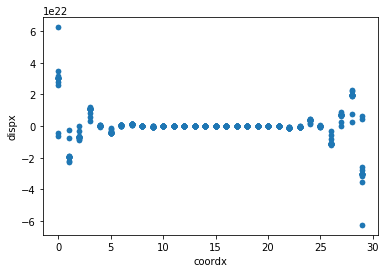

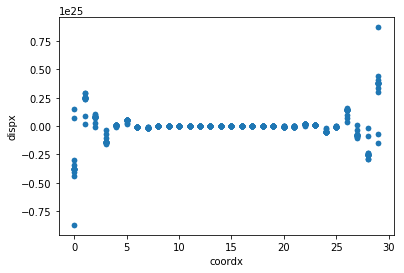

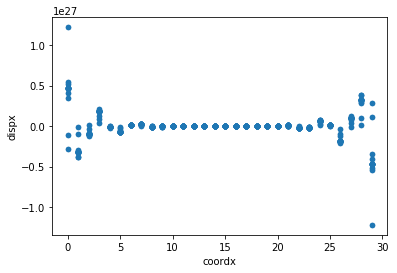

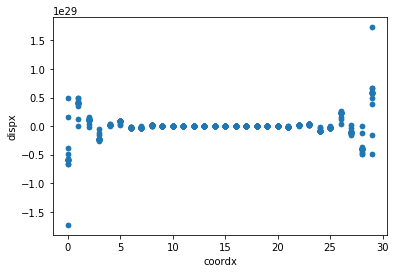

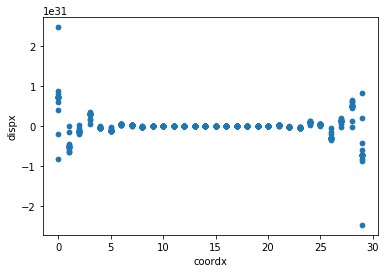

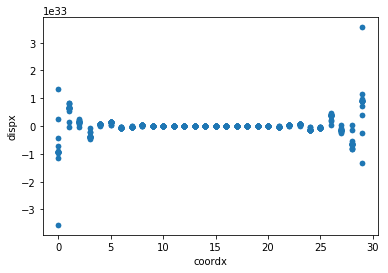

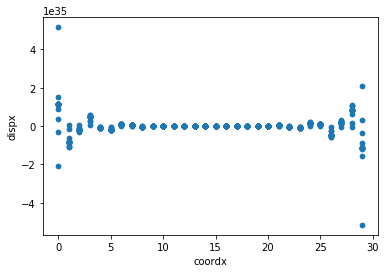

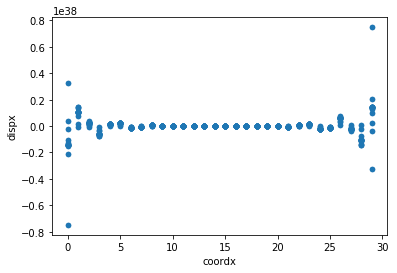

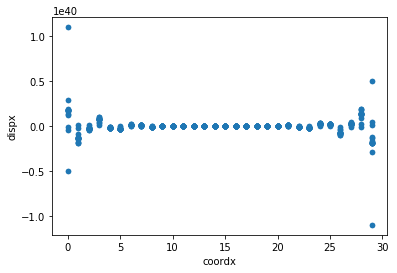

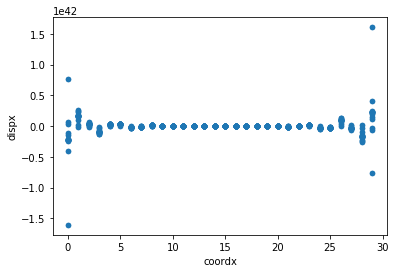

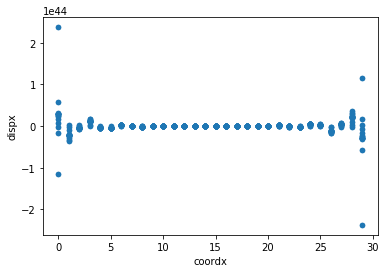

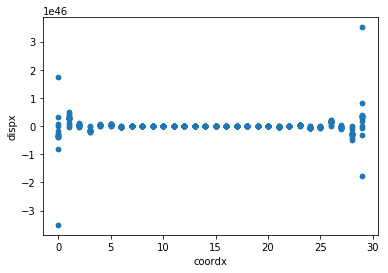

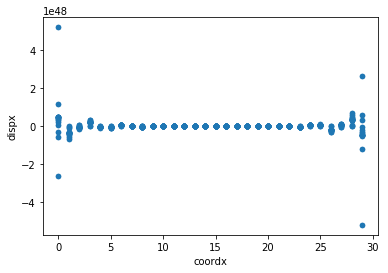

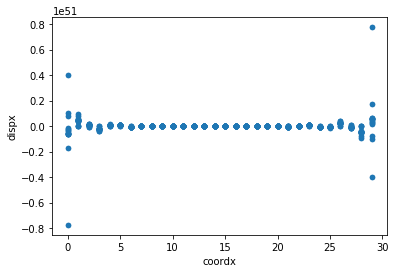

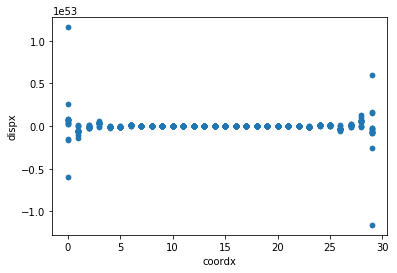

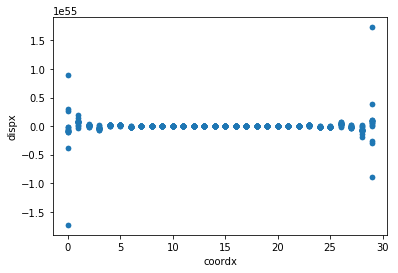

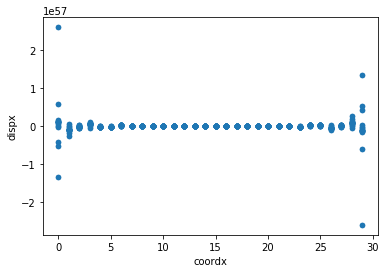

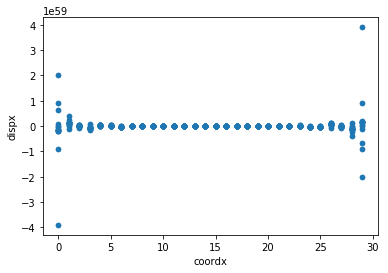

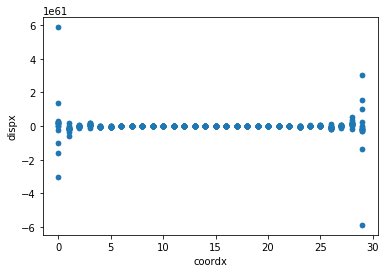

In [27]:
iterate(df,'uniaxial tensile loading',1,1000,applied = E*1e-9)